In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np

import io
from PIL import Image
from IPython.display import HTML
from IPython.display import clear_output

from utils import generate_dataset

/var/folders/n_/ykwl_b5n0gx9x4hp5z0fmvvr0000gn/T/ipykernel_53217/1738296773.py:6: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
eps = 1e-6
sigma_min = 0.001
sigma_max = 10
n_steps = 30 
annealed_step = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps')

In [3]:
class Model(nn.Module):
    def __init__(self, device, n_steps, sigma_min, sigma_max, p=0.5):
        '''
        Score Network.

        n_steps   : perturbation schedule steps (Langevin Dynamic step)
        sigma_min : sigma min of perturbation schedule
        sigma_min : sigma max of perturbation schedule

        '''
        super().__init__()
        self.device = device
        self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps)).to(device = device)
        
        self.linear_model1 = nn.Sequential(
            nn.Linear(2, 256),
            nn.Dropout(p),
            nn.GELU(),
            

        )
        # Condition sigmas
        self.embedding_layer = nn.Embedding(n_steps, 256)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.Dropout(p),
            nn.GELU(),
            
            nn.Linear(512, 512),
            nn.Dropout(p),
            nn.GELU(),
            
            nn.Linear(512, 2),
        )
        
        self.to(device = self.device)
        

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)
        
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)

        
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (score prediction)

        '''
        

        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0),)).to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            noise = torch.randn_like(x)
            x_tilde = x + noise * used_sigmas
            
        else:
            idx = torch.cat([torch.Tensor([idx for _ in range(x.size(0))])]).long().to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            x_tilde = x

        if get_target:
            target = - 1 / used_sigmas * noise

        output = self.linear_model1(x_tilde)
        embedding = self.embedding_layer(idx)
        output = self.linear_model2(output + embedding)

        return (output, target, used_sigmas) if get_target else output

In [4]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, L, T, score_fn, device, eps = 1e-1):
        '''
        sigma_min : minimum sigmas of perturbation schedule 
        sigma_max : maximum sigmas of perturbation schedule 
        L         : iteration step of Langevin dynamic
        T         : annelaed step of annealed Langevin dynamic
        score_fn  : trained score network
        eps       : coefficient of step size
        '''

        self.process = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps))
        self.step_size = eps * (self.process / self.process[-1] ) ** 2
        self.score_fn = score_fn
        self.annealed_step = annealed_step
        self.device = device

    def _one_annealed_step_iteration(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''

        self.score_fn.eval()
        z, step_size = torch.randn_like(x).to(device = self.device), self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        for _ in range(self.annealed_step):
            x = self._one_annealed_step_iteration(x, idx)
        return x

    def _one_perturbation_step(self, x):
        '''
        x   : sampling of prior distribution
        '''
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        only_final : If True, return is an only output of final schedule step 
        '''
        sample = (torch.rand([sampling_number,2]).to(device = self.device) - 0.5)*2
        sampling_list = []
        
        final = None
        for sample in self._one_perturbation_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
                

        return final if only_final else torch.stack(sampling_list)

In [5]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [45]:
def scatter(sample, only_final, scatter_range = [-0.5, 0.5]):
    clear_output()
    if only_final:
        scatter = sample.detach().cpu().numpy()
        scatter_x, scatter_y = scatter[:,0], scatter[:,1]
        plt.figure(figsize=(7, 7))

        plt.xlim(scatter_range)
        plt.ylim(scatter_range)
        plt.rc('axes', unicode_minus=False)

        plt.scatter(scatter_x, scatter_y, s=5)
        plt.show()
    
    else:
        step_size = sample.size(0)
        rows = int(np.sqrt(step_size))
        cols = int(step_size / rows)
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout = True)
        for i in range(rows):
            for j in range(cols):
                index = i * cols + j
                scatter = sample[index].detach().cpu().numpy()
                scatter_x, scatter_y = scatter[:,0], scatter[:,1]
                axs[i, j].scatter(scatter_x, scatter_y, s=5)
                axs[i, j].set_xlim(scatter_range)
                axs[i, j].set_ylim(scatter_range)
                # set the fond size of title and make it bold
                axs[i, j].title.set_fontsize(20)
                axs[i, j].title.set_fontweight('bold')
                axs[i, j].set_title('Step : {}'.format(index+1))
        plt.show()


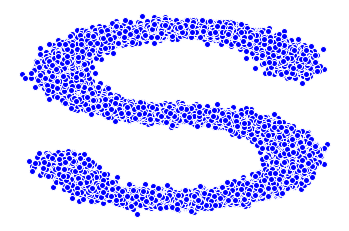

In [7]:
data = generate_dataset(10000)
dataset = torch.utils.data.TensorDataset(data)

In [8]:
model = Model(device, n_steps, sigma_min, sigma_max, p = 0.3)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)

In [9]:
batch_size = 256
total_iteration = 40000
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
dataiter = iter(dataloader)

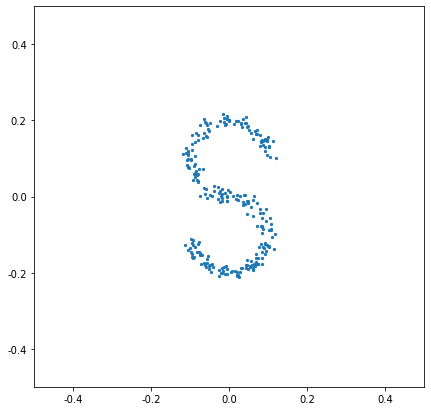

In [10]:
scatter(next(iter(dataloader))[0], True)

In [11]:
scatter_range = [-0.5, 0.5]
current_iteration = 0
display_iteration = 1000
sampling_number = 2000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

## Train

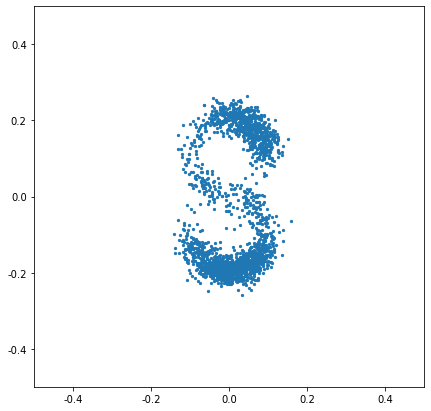

In [12]:
while current_iteration != total_iteration:
    try:
        data = dataiterator.next()[0]
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.__next__()[0]
    data = data.to(device = device)
    loss = model.loss_fn(data)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.update(loss.item())
    progress.display(current_iteration)
    
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
        sample = dynamic.sampling(sampling_number, only_final)
        scatter(sample, only_final, scatter_range = scatter_range)
        losses.reset()


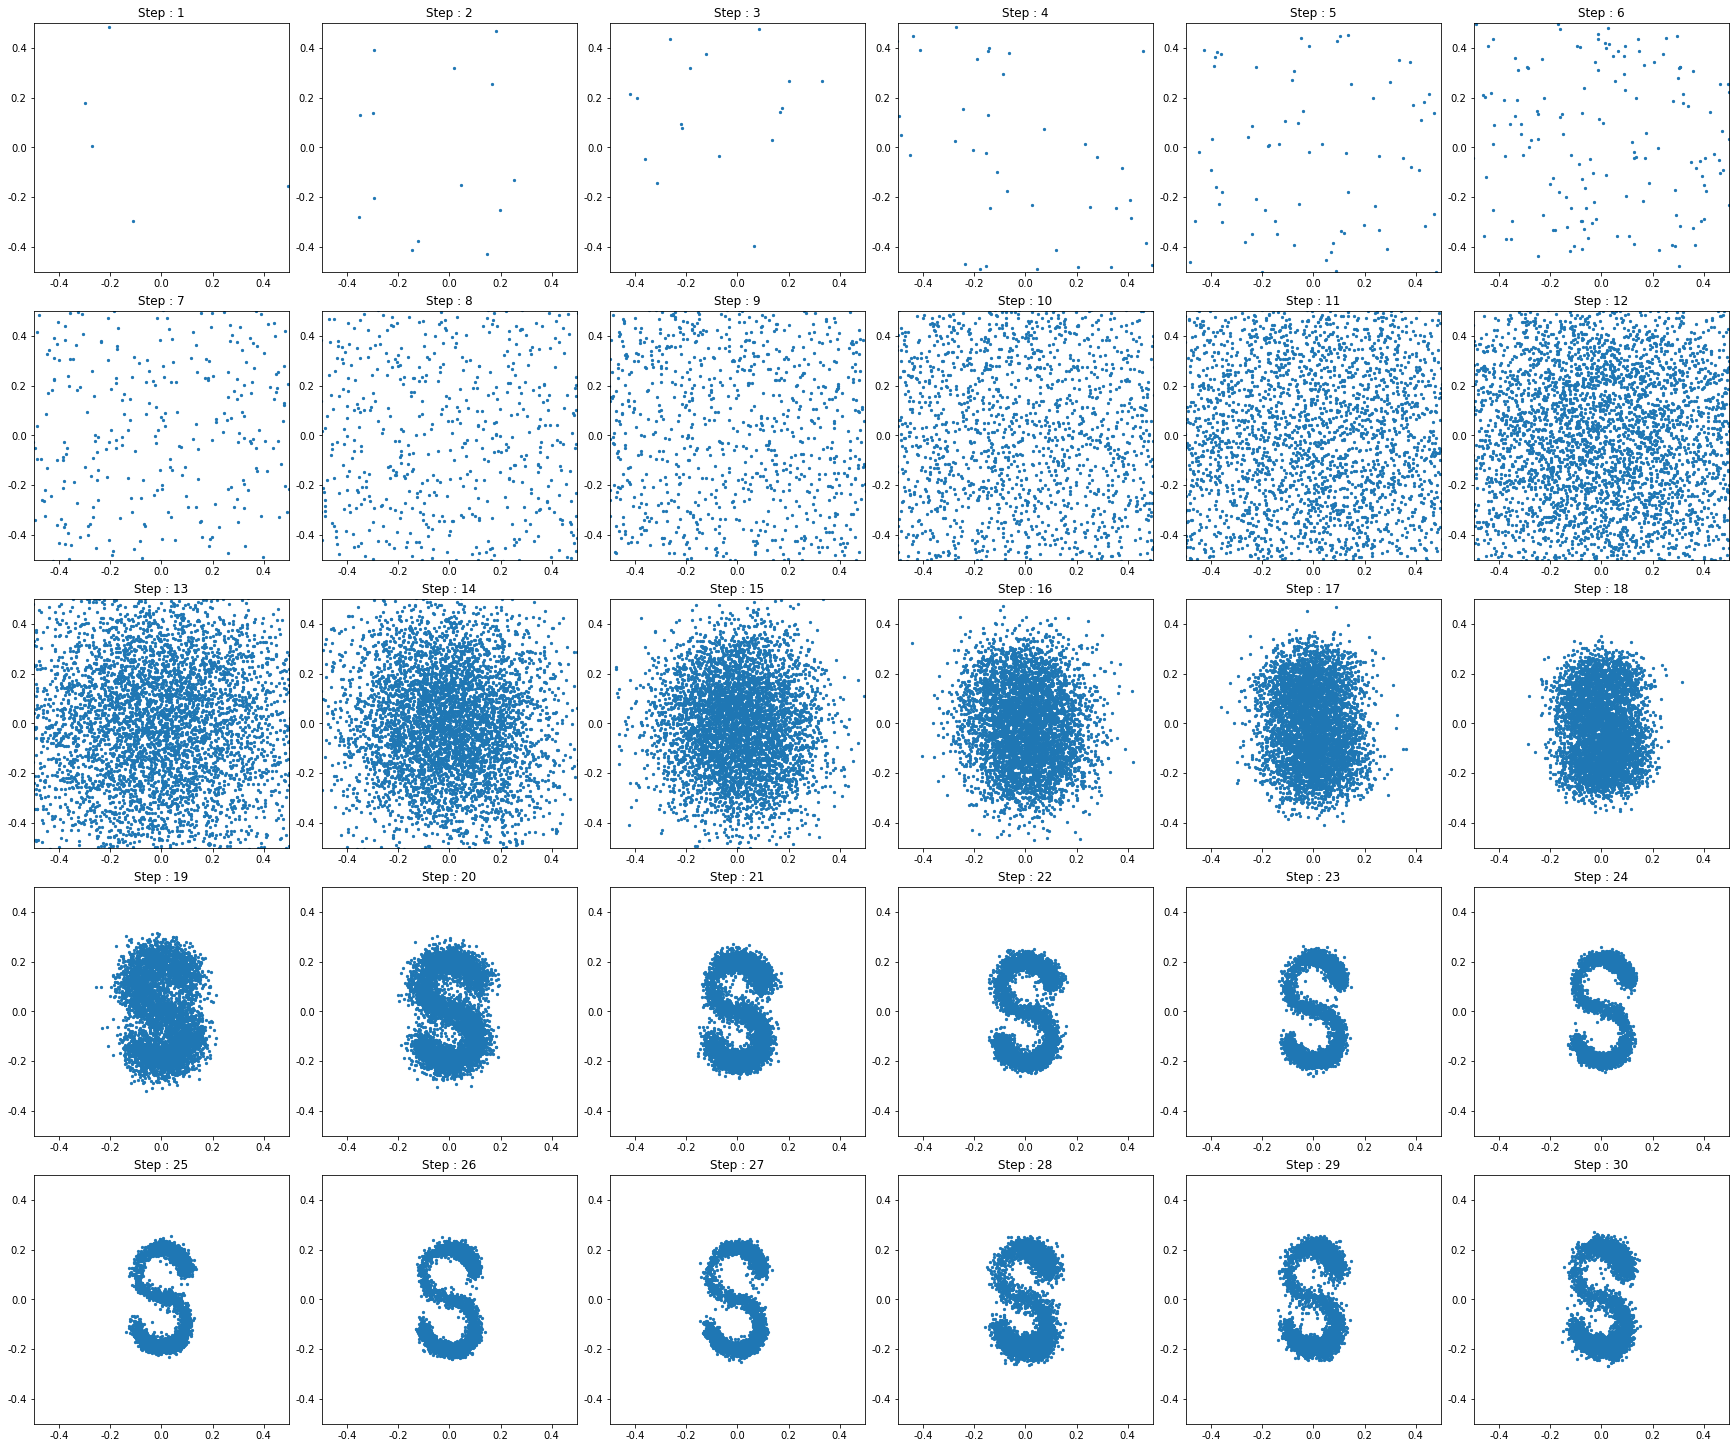

In [46]:
sampling_number = 5000
only_final = False
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range=scatter_range)

In [34]:
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=150)
# ani.save('ncsn_toy.gif')
HTML(ani.to_jshtml())

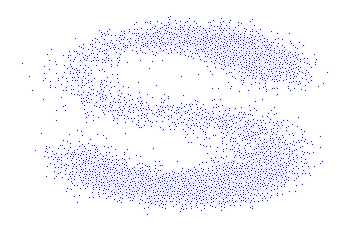

In [35]:
imgs = []
for i in range(numframes):
    plt.clf()
    scatter_point = sample[i].detach().cpu().numpy()
    scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

    scat = plt.scatter(scatter_x, scatter_y,color='blue', edgecolor='white', s=5)
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='jpg')
    img = Image.open(img_buf)
    imgs.append(img)

In [36]:
imgs[0].save("ncsn.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)

This gif shows the progress of how the sampling works.  
![output](output/ncsn/ncsn.gif)